# Importing Libraries

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
sgb = GradientBoostingClassifier(subsample = 0.90, max_features = 0.70)

In [2]:
path='~/kaggle/titanic/'

# Opening csv files as DataFrame

In [58]:
train_data=pd.read_csv(path+'train.csv')
test_data=pd.read_csv(path+'test.csv')
main_test_data=test_data

train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We take a quick look to our train data. It seems that there are some gaps in it.

In [4]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

At here we see that our **Age**, **Cabin** and **Embarked** features have empty values in our train data. Let's look for the test data

In [5]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# Data Visualization 

To have better insights we visualize our data with correlation matrix

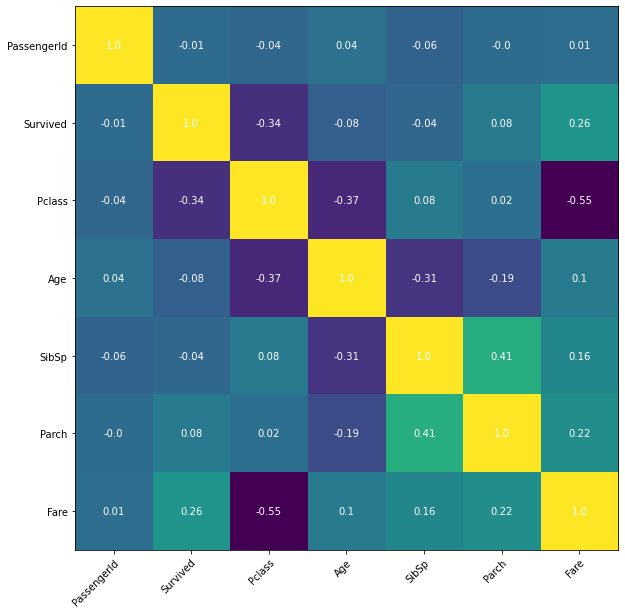

In [6]:
# Get correlation matrix
corr = train_data.corr()
fig, ax = plt.subplots(figsize=(10, 10))

# Create heatmap
im = ax.imshow(corr.values)

# Set labels
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = ax.text(j, i, np.around(corr.iloc[i, j], decimals=2),
                       ha="center", va="center", color="white")

We will drop the least correlated features and create new features with most correlated ones. With these features we will create a set of subsets. In this set, we will try to maximize the simularity of elements in the same subset and minimize the simularity between subsets.

To prepare our data we have to change the structure and then try to fill empty values

# Data Preparation

Luckily we won't be dealing with empty name columns. Since **Pclass** is correlated, we can colonize titles in the passenger names which is also correlated with Pclass. Also **Sex** would have a correlation, so we will change the **male** with **0** and **female** with **1**.

In [7]:
# Separeting titles from names 

train_data.insert(2, "Title", "Title")
for i in range(len(train_data['Name'])):
    train_data["Title"][i]=train_data['Name'][i].split(",")[1].split(".")[0]
    
test_data.insert(2, "Title", "Title")
for i in range(len(test_data['Name'])):
    test_data["Title"][i]=test_data['Name'][i].split(",")[1].split(".")[0]

<ipython-input-7-8169c5a75c91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["Title"][i]=train_data['Name'][i].split(",")[1].split(".")[0]
<ipython-input-7-8169c5a75c91>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["Title"][i]=test_data['Name'][i].split(",")[1].split(".")[0]


In [8]:
# Categorizing train dataset titles 

train_data.loc[(train_data.Sex == 'male'),'Sex']=0
train_data.loc[(train_data.Sex == 'female'),'Sex']=1

train_data['Title'].mask(train_data['Title'] == ' Mrs', 1, inplace=True)
train_data['Title'].mask(train_data['Title'] == ' Miss', 1, inplace=True)
train_data['Title'].mask(train_data['Title'] == ' Ms', 1, inplace=True)
train_data['Title'].mask(train_data['Title'] == ' Mlle', 1, inplace=True)
train_data['Title'].mask(train_data['Title'] == ' Mme', 1, inplace=True)
train_data['Title'].mask(train_data['Title'] == ' the Countess', 1, inplace=True)
train_data['Title'].mask(train_data['Title'] == ' Lady', 1, inplace=True)

train_data['Title'].mask(train_data['Title'] == ' Master', 2, inplace=True)

train_data['Title'].mask(train_data['Title'] == ' Dr', 3, inplace=True)
train_data['Title'].mask(train_data['Title'] == ' Don', 3, inplace=True)
train_data['Title'].mask(train_data['Title'] == ' Sir', 3, inplace=True)
train_data['Title'].mask(train_data['Title'] == ' Col', 3, inplace=True)
train_data['Title'].mask(train_data['Title'] == ' Capt', 3, inplace=True)
train_data['Title'].mask(train_data['Title'] == ' Major', 3, inplace=True)

train_data['Title'].mask(train_data['Title'] == ' Mr', 4, inplace=True)

train_data['Title'].mask(train_data['Title'] == ' Rev', 5, inplace=True)
train_data['Title'].mask(train_data['Title'] == ' Jonkheer', 5, inplace=True)

# Categorizing test dataset titles 

test_data.loc[(test_data.Sex == 'male'),'Sex']=0
test_data.loc[(test_data.Sex == 'female'),'Sex']=1

test_data['Title'].mask(test_data['Title'] == ' Mrs', 1, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' Miss', 1, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' Ms', 1, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' Mlle', 1, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' Mme', 1, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' the Countess', 1, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' Lady', 1, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' Dona', 1, inplace=True)

test_data['Title'].mask(test_data['Title'] == ' Master', 2, inplace=True)

test_data['Title'].mask(test_data['Title'] == ' Dr', 3, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' Don', 3, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' Sir', 3, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' Col', 3, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' Capt', 3, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' Major', 3, inplace=True)

test_data['Title'].mask(test_data['Title'] == ' Mr', 4, inplace=True)

test_data['Title'].mask(test_data['Title'] == ' Rev', 5, inplace=True)
test_data['Title'].mask(test_data['Title'] == ' Jonkheer', 5, inplace=True)

We create a feature named FamilySize. The idea behind this feature is we can not easily guess a passenger's survival status because of reality factor. Which is there may some accidents on the way of leaving the ship. Since the families are moving together, this would be changing the survival result.

In [9]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch']+1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch']+1

train_data.loc[train_data['FamilySize']==1, 'FamilySize']=0
train_data.loc[(train_data['FamilySize']>1) & (train_data['FamilySize']<=3), 'FamilySize']=1
train_data.loc[(train_data['FamilySize']>3) & (train_data['FamilySize']<=5), 'FamilySize']=2
train_data.loc[(train_data['FamilySize']>5), 'FamilySize']=3

test_data.loc[test_data['FamilySize']==1, 'FamilySize']=0
test_data.loc[(test_data['FamilySize']>1) & (test_data['FamilySize']<=3), 'FamilySize']=1
test_data.loc[(test_data['FamilySize']>3) & (test_data['FamilySize']<=5), 'FamilySize']=2
test_data.loc[(test_data['FamilySize']>5), 'FamilySize']=3

In [10]:
train_data[train_data['Embarked'].isna()]

,PassengerId,Survived,Title,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
61,62,1,1,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN,0
829,830,1,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN,0


We have some empty values for the Embarked and Fare features. For the sake of the count, we can manually fill the empty values.

In [11]:
train_data['Embarked']=train_data['Embarked'].fillna('Q')

Same thing for the Fare value in test data.

In [12]:
test_data[test_data['Fare'].isna()]

,PassengerId,Pclass,Title,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
152,1044,3,4,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,S,0


In [13]:
test_data['Fare']=test_data['Fare'].fillna(test_data[test_data['Pclass']==3]['Fare'].mean())

We have lot's of empty values in **Age** column. To do this we will look for the Pclass of the passenger. Since the mean value of Pclass=1 and mean value of males in Pclass=1 are different, we will look for the Passenger's gender. If the passenger's Age value is missing we fill with mean value of the related Pclass with same gender.

In [14]:
train_data_age=train_data[['Pclass','Age','Sex']].copy()
test_data_age=test_data[['Pclass','Age','Sex']].copy
train_men_age=[]
train_women_age=[]

test_men_age=[]
test_women_age=[]

for i in train_data['Pclass'].unique():
    train_men_age.append(train_data_age.loc[(train_data_age['Pclass']==i) & (train_data_age['Sex']==0)].mean())
    train_women_age.append(train_data_age.loc[(train_data_age['Pclass']==i) & (train_data_age['Sex']==1)].mean())
    
    # We do the same mean value calculation from train data for test data since there are more records.
    test_men_age.append(train_data_age.loc[(train_data_age['Pclass']==i) & (train_data_age['Sex']==0)].mean())
    test_women_age.append(train_data_age.loc[(train_data_age['Pclass']==i) & (train_data_age['Sex']==1)].mean())

In [15]:
def impute_age_train(cols):
    Age = cols[0]
    Pclass = cols[1]
    Sex = cols[2]
    
    if pd.isnull(Age) and Sex==0:
        if Pclass==1:
            return train_men_age[1][1]

        if Pclass==2:
            return train_men_age[2][1]
        
        if Pclass==3:
            return train_men_age[0][1]

    elif pd.isnull(Age) and Sex==1: 

        if Pclass==1:
            return train_women_age[1][1]
        
        if Pclass==2:
            return train_women_age[2][1]
        
        if Pclass==3:
            return train_women_age[0][1]

    else:
        return Age

def impute_age_test(cols):
    Age = cols[0]
    Pclass = cols[1]
    Sex = cols[2]
    
    if pd.isnull(Age) and Sex==0:
        if Pclass==1:
            return test_men_age[1][1]

        if Pclass==2:
            return test_men_age[2][1]
        
        if Pclass==3:
            return test_men_age[0][1]

    elif pd.isnull(Age) and Sex==1: 

        if Pclass==1:
            return test_women_age[1][1]
        
        if Pclass==2:
            return test_women_age[2][1]
        
        if Pclass==3:
            return test_women_age[0][1]

    else:
        return Age


In [16]:
train_data['Age'] = train_data[['Age', 'Pclass','Sex']].apply(impute_age_train, axis=1)
test_data['Age']=test_data[['Age', 'Pclass','Sex']].apply(impute_age_test, axis=1)

In [17]:
train_data.drop(['SibSp','Parch'], axis=1, inplace=True)
test_data.drop(['SibSp','Parch'], axis=1, inplace=True)

We encode non-numerical features in binary classification.

In [18]:
non_numeric=['Sex','Embarked','Title']

for feature in non_numeric:
    train_data[feature]=LabelEncoder().fit_transform(train_data[feature])
    test_data[feature]=LabelEncoder().fit_transform(test_data[feature])

In [19]:
cat_feats = ['Sex', 'Embarked', 'Pclass', 'Title', 'FamilySize']

encoded_train_df_feats = []

for feature in cat_feats:
    encoded_feats_train = OneHotEncoder().fit_transform(train_data[feature].values.reshape(-1,1)).toarray()
    n = train_data[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n+1)]
    encoded_df = pd.DataFrame(encoded_feats_train, columns=cols)
    encoded_df.index = train_data.index
    encoded_train_df_feats.append(encoded_df)

In [20]:
encoded_test_df_feats = []

for feature in cat_feats:
    encoded_feats_test = OneHotEncoder().fit_transform(test_data[feature].values.reshape(-1,1)).toarray()
    n = test_data[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n+1)]
    encoded_dft = pd.DataFrame(encoded_feats_test, columns=cols)
    encoded_dft.index = test_data.index
    encoded_test_df_feats.append(encoded_dft)

In [21]:
train_data=pd.concat([train_data, *encoded_train_df_feats], axis=1)
test_data=pd.concat([test_data, *encoded_test_df_feats], axis=1)

We now drop unnecessary columns

In [22]:
drop_columns=['Name','Pclass','Sex','Title','Embarked','FamilySize']

del train_data['PassengerId']
del test_data['PassengerId']

del train_data['Ticket']
del test_data['Ticket']

del train_data['Cabin']
del test_data['Cabin']

In [23]:
train_data.drop(columns=drop_columns,inplace=True)
test_data.drop(columns=drop_columns,inplace=True)

# Train the model

In [24]:
X=train_data.drop('Survived',axis=1)
y=train_data['Survived']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=49)

# Random Forest Classifier

In [25]:
rfc = RandomForestClassifier(n_estimators=190)
rfc.fit(X_train, y_train)
prediction3 = rfc.predict(X_test)

In [26]:
print('Confusion Matrix:\n', confusion_matrix(y_test, prediction3))
print('\n')
print('Classification Report:\n', classification_report(y_test, prediction3))

Confusion Matrix:
 [[161  17]
 [ 18  72]]


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       178
           1       0.81      0.80      0.80        90

    accuracy                           0.87       268
   macro avg       0.85      0.85      0.85       268
weighted avg       0.87      0.87      0.87       268



# Support Vector Machines

In [27]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
predictions4 = svc_model.predict(X_test)

In [28]:
print('Confusion Matrix:\n', confusion_matrix(y_test, predictions4))
print('\n')
print('Classification Report:\n', classification_report(y_test, predictions4))

Confusion Matrix:
 [[159  19]
 [ 59  31]]


Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.89      0.80       178
           1       0.62      0.34      0.44        90

    accuracy                           0.71       268
   macro avg       0.67      0.62      0.62       268
weighted avg       0.69      0.71      0.68       268



In [45]:
param_grid_svm = {'C':[0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001]}
rndm_cv = RandomizedSearchCV(estimator=svc_model, param_distributions=param_grid_svm, cv=10, verbose=2)
rndm_cv.fit(X_train, y_train)
rndm_preds = rndm_cv.predict(X_test)
print('Confusion Matrix:\n', confusion_matrix(y_test, rndm_preds))
print('\n')
print('Classification Report:\n', classification_report(y_test, rndm_preds))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ......................................C=10, gamma=1; total time=   0.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=   0.0s
[CV] END ...................................C=

# Stochastic Gradient Boosting

In [29]:
sgb.fit(X_train, y_train)

GradientBoostingClassifier(max_features=0.7, subsample=0.9)

In [30]:
sgb_preds = sgb.predict(X_test)

In [31]:
print("Confusion Matrix:\n",confusion_matrix(y_test, sgb_preds))
print("Classification Report:\n",classification_report(y_test, sgb_preds))

Confusion Matrix:
 [[159  19]
 [ 20  70]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89       178
           1       0.79      0.78      0.78        90

    accuracy                           0.85       268
   macro avg       0.84      0.84      0.84       268
weighted avg       0.85      0.85      0.85       268



# XG Boost

In [32]:
xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180)
xgb.fit(X_train, y_train)

[08:38:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=180, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
xgb_preds = xgb.predict(X_test)


In [34]:
print("Confusion Matrix:\n",confusion_matrix(y_test, xgb_preds))
print("Classification Report:\n", classification_report(y_test, xgb_preds))

Confusion Matrix:
 [[161  17]
 [ 20  70]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90       178
           1       0.80      0.78      0.79        90

    accuracy                           0.86       268
   macro avg       0.85      0.84      0.84       268
weighted avg       0.86      0.86      0.86       268



# Logistic Regression

In [35]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [36]:
logmodel = LogisticRegression(max_iter=200)
logmodel.fit(X_train, y_train)
prediction1 = logmodel.predict(X_test)

In [37]:
print('Confusion Matrix:\n', confusion_matrix(y_test, prediction1))
print('\n')
print('Classification Report:\n', classification_report(y_test, prediction1))

Confusion Matrix:
 [[149  29]
 [ 20  70]]


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86       178
           1       0.71      0.78      0.74        90

    accuracy                           0.82       268
   macro avg       0.79      0.81      0.80       268
weighted avg       0.82      0.82      0.82       268



# KNeighborsClassifier

In [38]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
prediction2 = knn.predict(X_test)

In [39]:
print('Confusion Matrix:\n', confusion_matrix(y_test, prediction2))
print('\n')
print('Classification Report:\n', classification_report(y_test, prediction2))

Confusion Matrix:
 [[151  27]
 [ 20  70]]


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.87       178
           1       0.72      0.78      0.75        90

    accuracy                           0.82       268
   macro avg       0.80      0.81      0.81       268
weighted avg       0.83      0.82      0.83       268



# Results

In [46]:
rfc_acc = accuracy_score(y_test, prediction3)
SVM_acc = accuracy_score(y_test, rndm_preds)
sgb_acc = accuracy_score(y_test, sgb_preds)
xgb_acc = accuracy_score(y_test, xgb_preds)
lr_acc = accuracy_score(y_test, prediction1)
knn_acc = accuracy_score(y_test, prediction2)

In [47]:
model = ['Random Forests','Support Vector Machines','Stochastic Gradient Booster','XGBoost','Logistic Regression', 'K Nearest Neighbors']
score = [ rfc_acc, SVM_acc,sgb_acc, xgb_acc,lr_acc, knn_acc]

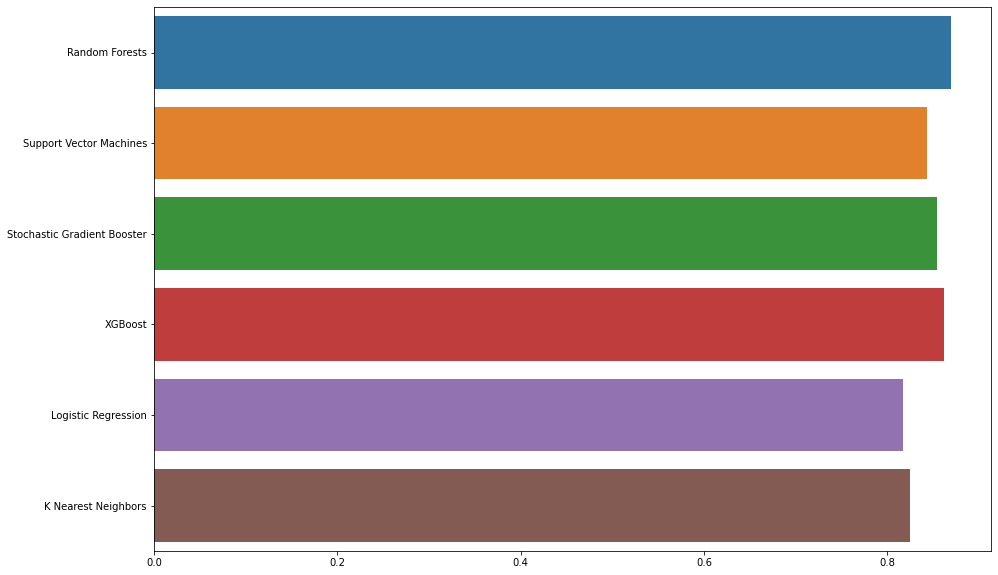

In [48]:
plt.figure(figsize = (15, 10))
sns.barplot(x = score, y = model)
plt.show()

In [52]:
predictions = rfc.predict(test_data)

In [63]:
predictions

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [59]:
submission = pd.DataFrame({'PassengerId':main_test_data['PassengerId'],'Survived':predictions})

In [61]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [62]:
filename = '1_titanic_prediction.csv'
submission.to_csv(filename,index=False)

# References

1. https://www.kaggle.com/jlawman/complete-beginner-your-first-titanic-submission
2. https://www.kaggle.com/arunsajisamuel/titanic-eda-and-predictions-top-13